# ConvLSTM for Patches
Trains a convolutional LSTM. The model input is a stack of 64x64 patches of the total area of interest, and the model output is a 64x64 patch with the predicted land type at the next time step. Requires about 12 GB RAM to run.

In [1]:
%matplotlib inline
import keras_core as keras
import tensorflow as tf
import numpy as np
import rasterio
import random
import matplotlib.pyplot as plt
from glob import glob

Using TensorFlow backend


In [2]:
SEED = 42
rng = np.random.default_rng(SEED)

Define parameters for patch size.

In [5]:
PATCH_SIZE = 64  # Size of each patch in pixels
OVERLAP_SIZE = 64  # Number of pixels to advance before accessing the next patch
MAX_EMPTY_RATIO = 0.4  # Maximum percent of pixels in the image that can be zero
MIN_CHANGE_RATIO = 0.05  # Minimum percent of pixels that must change from the earliest to latest timestamp in the dataset
TIME_STEPS = 5  # Number of time steps

## Dataset Generation
Read all input files and stack them on top of each other to create a large numpy array.

In [4]:
images = []
for f in glob('data/CONUS20*_ClipAOI*.tif'):
    with rasterio.open(f) as ds:
        data = ds.read(1)
        images.append(data)
images = np.array(images)
n_times = images.shape[0]
images.shape

(9, 17975, 35165)

Compute 2D prefix sum arrays for the entire large image. When passing patches to the model during training, we want to exclude patches where the entire image or the majority of pixels are out of bounds (zero), and also images where the terrain is almost completely unchanged. Calculating the prefix sum arrays for the entire large image will allow fast querying of the number of zero pixels in any given patch.

In [5]:
image = images[0, :, :]
zero_prefix = np.zeros_like(image, dtype=np.uint32)
zero_prefix[image == 0] = 1
zero_prefix = np.cumsum(np.cumsum(zero_prefix, axis=0, dtype=np.uint32), axis=1, dtype=np.uint32)
zero_prefix.shape

(17975, 35165)

In [6]:
def get_zero_pixels(i, j):
    """Calculates the number of zero pixels in the patch with corner at (i, j)."""
    zeros = zero_prefix[i + PATCH_SIZE - 1, j + PATCH_SIZE - 1]
    if i > 0 and j > 0:
        zeros += zero_prefix[i - 1, j - 1]
    if i > 0:
        zeros -= zero_prefix[i - 1, j + PATCH_SIZE - 1]
    if j > 0:
        zeros -= zero_prefix[i + PATCH_SIZE - 1, j - 1]
    return zeros

In [7]:
change_prefix = np.zeros_like(image, dtype=np.uint32)
change_prefix[images[0, :, :] != images[-1, :, :]] = 1
change_prefix = np.cumsum(np.cumsum(change_prefix, axis=0, dtype=np.uint32), axis=1, dtype=np.uint32)
change_prefix.shape

(17975, 35165)

In [8]:
def get_changed_pixels(i, j):
    """Calculates the number of changed pixels in the patch with corner at (i, j)."""
    changes = change_prefix[i + PATCH_SIZE - 1, j + PATCH_SIZE - 1]
    if i > 0 and j > 0:
        changes += change_prefix[i - 1, j - 1]
    if i > 0:
        changes -= change_prefix[i - 1, j + PATCH_SIZE - 1]
    if j > 0:
        changes -= change_prefix[i + PATCH_SIZE - 1, j - 1]
    return changes

Determine the possible categories and normalize them to integer values starting at 0.

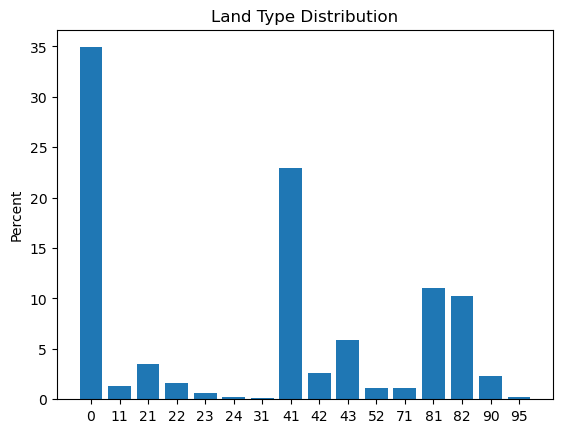

{0: 0,
 11: 1,
 21: 2,
 22: 3,
 23: 4,
 24: 5,
 31: 6,
 41: 7,
 42: 8,
 43: 9,
 52: 10,
 71: 11,
 81: 12,
 82: 13,
 90: 14,
 95: 15}

In [18]:
categories, counts = np.unique(image, return_counts=True)
np.save('categories.npy', categories)
n_categories = categories.shape[0]
category_map = {categories[i]: i for i in range(n_categories)}
percents = counts / image.size * 100
del image
plt.bar(list(map(str, categories)), percents)
plt.title('Land Type Distribution')
plt.ylabel('Percent')
plt.show()
category_map

Using the prefix sum arrays, find the indices of every patch in the dataset that lies in the area of interest and has enough changed pixels

In [10]:
indices = []
for i in range(0, images.shape[1] - PATCH_SIZE, OVERLAP_SIZE):
    for j in range(0, images.shape[2] - PATCH_SIZE, OVERLAP_SIZE):
        zeros = get_zero_pixels(i, j)
        if zeros >= PATCH_SIZE * PATCH_SIZE * MAX_EMPTY_RATIO:
            continue
        changes = get_changed_pixels(i, j)
        if changes >= PATCH_SIZE * PATCH_SIZE * MIN_CHANGE_RATIO:
            continue
        indices.append((i, j))
del zero_prefix, change_prefix
indices = np.array(indices)
rng.shuffle(indices)
indices.shape

(4423, 2)

## Training the Model
Define training parameters.

In [11]:
BATCH_SIZE = 32
EPOCHS = 1
VAL_SPLIT = 0.1

In [12]:
val_size = int(indices.shape[0] * VAL_SPLIT)
val_indices = indices[:val_size, :]
train_indices = indices[val_size:, :]
train_indices.shape, val_indices.shape

((3981, 2), (442, 2))

Build the dataset using the list of patch indices. The full dataset is generated in-place using a generator function because it would be too large to fit in memory.

In [23]:
def one_hot(x):
    encoded = np.zeros(x.shape + (n_categories,), dtype=np.uint8)
    for category, index in category_map.items():
        category_mask = (x == category)
        encoded[category_mask, index] = 1
    return encoded

def get_data(indices):
    sparse_encoder = np.vectorize(lambda x: category_map[x], otypes=[np.uint8])
    for i, j in indices:
        for k in range(n_times - TIME_STEPS):
            x = one_hot(images[k:k + TIME_STEPS, i:i + PATCH_SIZE, j:j + PATCH_SIZE])
            y = sparse_encoder(images[k + TIME_STEPS, i:i + PATCH_SIZE, j:j + PATCH_SIZE])
            yield x, y

In [14]:
train_ds = tf.data.Dataset.from_generator(
    lambda: get_data(train_indices),
    output_signature=(
        tf.TensorSpec(shape=(TIME_STEPS, PATCH_SIZE, PATCH_SIZE, n_categories), dtype=tf.float32),
        tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE), dtype=tf.uint8)
    )
)
# Tell Keras the full size of the dataset so we get ETA in the progress bar
train_ds = train_ds.apply(tf.data.experimental.assert_cardinality(train_indices.shape[0] * (n_times - TIME_STEPS)))
train_ds = train_ds.batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_generator(
    lambda: get_data(val_indices),
    output_signature=(
        tf.TensorSpec(shape=(TIME_STEPS, PATCH_SIZE, PATCH_SIZE, n_categories), dtype=tf.float32),
        tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE), dtype=tf.uint8)
    )
)
val_ds = val_ds.apply(tf.data.experimental.assert_cardinality(val_indices.shape[0] * (n_times - TIME_STEPS)))
val_ds = val_ds.batch(BATCH_SIZE)

2024-01-16 04:52:53.448633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [15]:
model = keras.Sequential([
    keras.layers.Input(shape=(TIME_STEPS, PATCH_SIZE, PATCH_SIZE, n_categories)),
    keras.layers.ConvLSTM2D(64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.ConvLSTM2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(n_categories, kernel_size=(3, 3), padding='same', activation='softmax')
])
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 64, 64, 64)     │    184,576 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 5, 64, 64, 64)     │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 64, 64, 64)        │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)        │      9,232 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 489,232 (1.87 MB)

 Trainable params: 489,104 (1.87 MB)

 Non-trainable params: 128 (512.00 B)

In [16]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

2024-01-16 04:52:57.967322: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a6dcf2b5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 04:52:57.967409: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-01-16 04:52:58.148058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-16 04:52:58.421215: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-01-16 04:53:02.693329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-01-16 04:53:13.640376: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for t

497/498 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - acc: 0.9592 - loss: 0.1973

2024-01-16 04:57:48.938472: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - acc: 0.9592 - loss: 0.1971

2024-01-16 04:57:55.038381: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-01-16 04:58:08.797196: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


498/498 ━━━━━━━━━━━━━━━━━━━━ 316s 595ms/step - acc: 0.9593 - loss: 0.1968 - val_acc: 0.9926 - val_loss: 0.1648


In [17]:
model.save('lttn-convlstm-patches.keras')

## Making predictions
Load the saved model (optional if run from the same session used to train above)

In [2]:
model = keras.saving.load_model('lttn-convlstm-patches.keras')
model.summary()

/Users/isaac/miniconda3/envs/ds/lib/python3.10/site-packages/keras_core/src/trainers/trainer.py:204: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 64, 64, 64)     │    184,576 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 5, 64, 64, 64)     │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 64, 64, 64)        │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)        │      9,232 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,467,442 (5.60 MB)

 Trainable params: 489,104 (1.87 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 978,210 (3.73 MB)

In [22]:
categories = np.load('categories.npy')
n_categories = categories.shape[0]
category_map = {categories[i]: i for i in range(n_categories)}
category_map

{0: 0,
 11: 1,
 21: 2,
 22: 3,
 23: 4,
 24: 5,
 31: 6,
 41: 7,
 42: 8,
 43: 9,
 52: 10,
 71: 11,
 81: 12,
 82: 13,
 90: 14,
 95: 15}

Run the model to predict the landscape of a random patch.

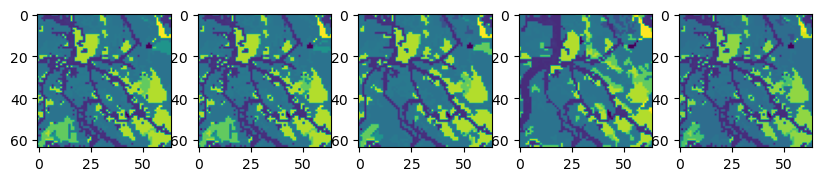

In [34]:
x = random.randint(2000, 16000)
y = random.randint(3000, 32000)
patch = images[-TIME_STEPS:, x:x + PATCH_SIZE, y:y + PATCH_SIZE]
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
for i, ax in enumerate(axs):
    ax.imshow(patch[i, :, :])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


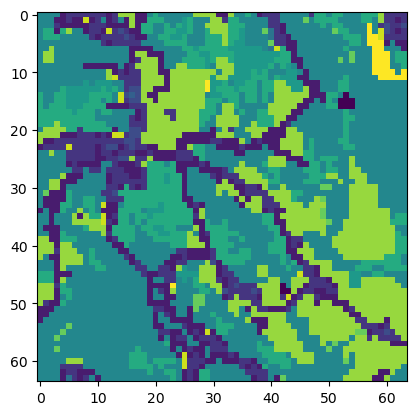

In [35]:
patch = one_hot(patch)
patch = np.expand_dims(patch, axis=0)
result = model.predict(patch)
result = np.squeeze(result, axis=0)
result = np.argmax(result, axis=-1)
plt.imshow(result)
plt.show()